# はじめに
機械学習モデルの出力から、どの程度プライバシーが漏洩する危険性があるかを評価します。  


### 概要
- メンバーシップ推定攻撃で、モデルが教師データをどの程度記憶しているか評価する。
- 機械学習モデルを用いて、教師データに含まれていたか判定するメンバーシップ推定攻撃の成功率を確認する。  


### 参考資料
- R. Shokri et al., Membership Inference Attacks Against Machine Learning Models, IEEE S&P, 2017  
https://www.computer.org/csdl/proceedings-article/sp/2017/07958568/12OmNBUAvVc
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# メンバーシップ推定攻撃
メンバーシップ推定攻撃は、教師データがどの程度モデルに記憶されているかに基づいて、プライバシー侵害の危険性を評価する際に用いられます。

### 基本的な考え方
下記の図のように、あるデータ（以降、ターゲット）を含まないデータセットと、ターゲットをデータを含むデータセットで学習したモデル$F_{out}$と$F_{in}$を考えます。  
メンバーシップ推定攻撃に基づくプライバシー評価では、モデルがターゲットを記憶した場合、ターゲットがモデルに含まれていたかどうかでモデルの出力が大きく変化する点に着目しています。  
つまり、モデルがターゲットを記憶していた場合、ターゲットが教師データに含まれていたかどうかの判定は、容易に行うことができるはずです。  

まとめると、  
　　教師データに含まれていたかを判定可能（メンバーシップ推定攻撃が成功） ⇒ モデルが教師データを記憶 ⇒ 教師データのプライバシーが保護されていない  
という考えに基づいてプライバシー保護の評価を行います。





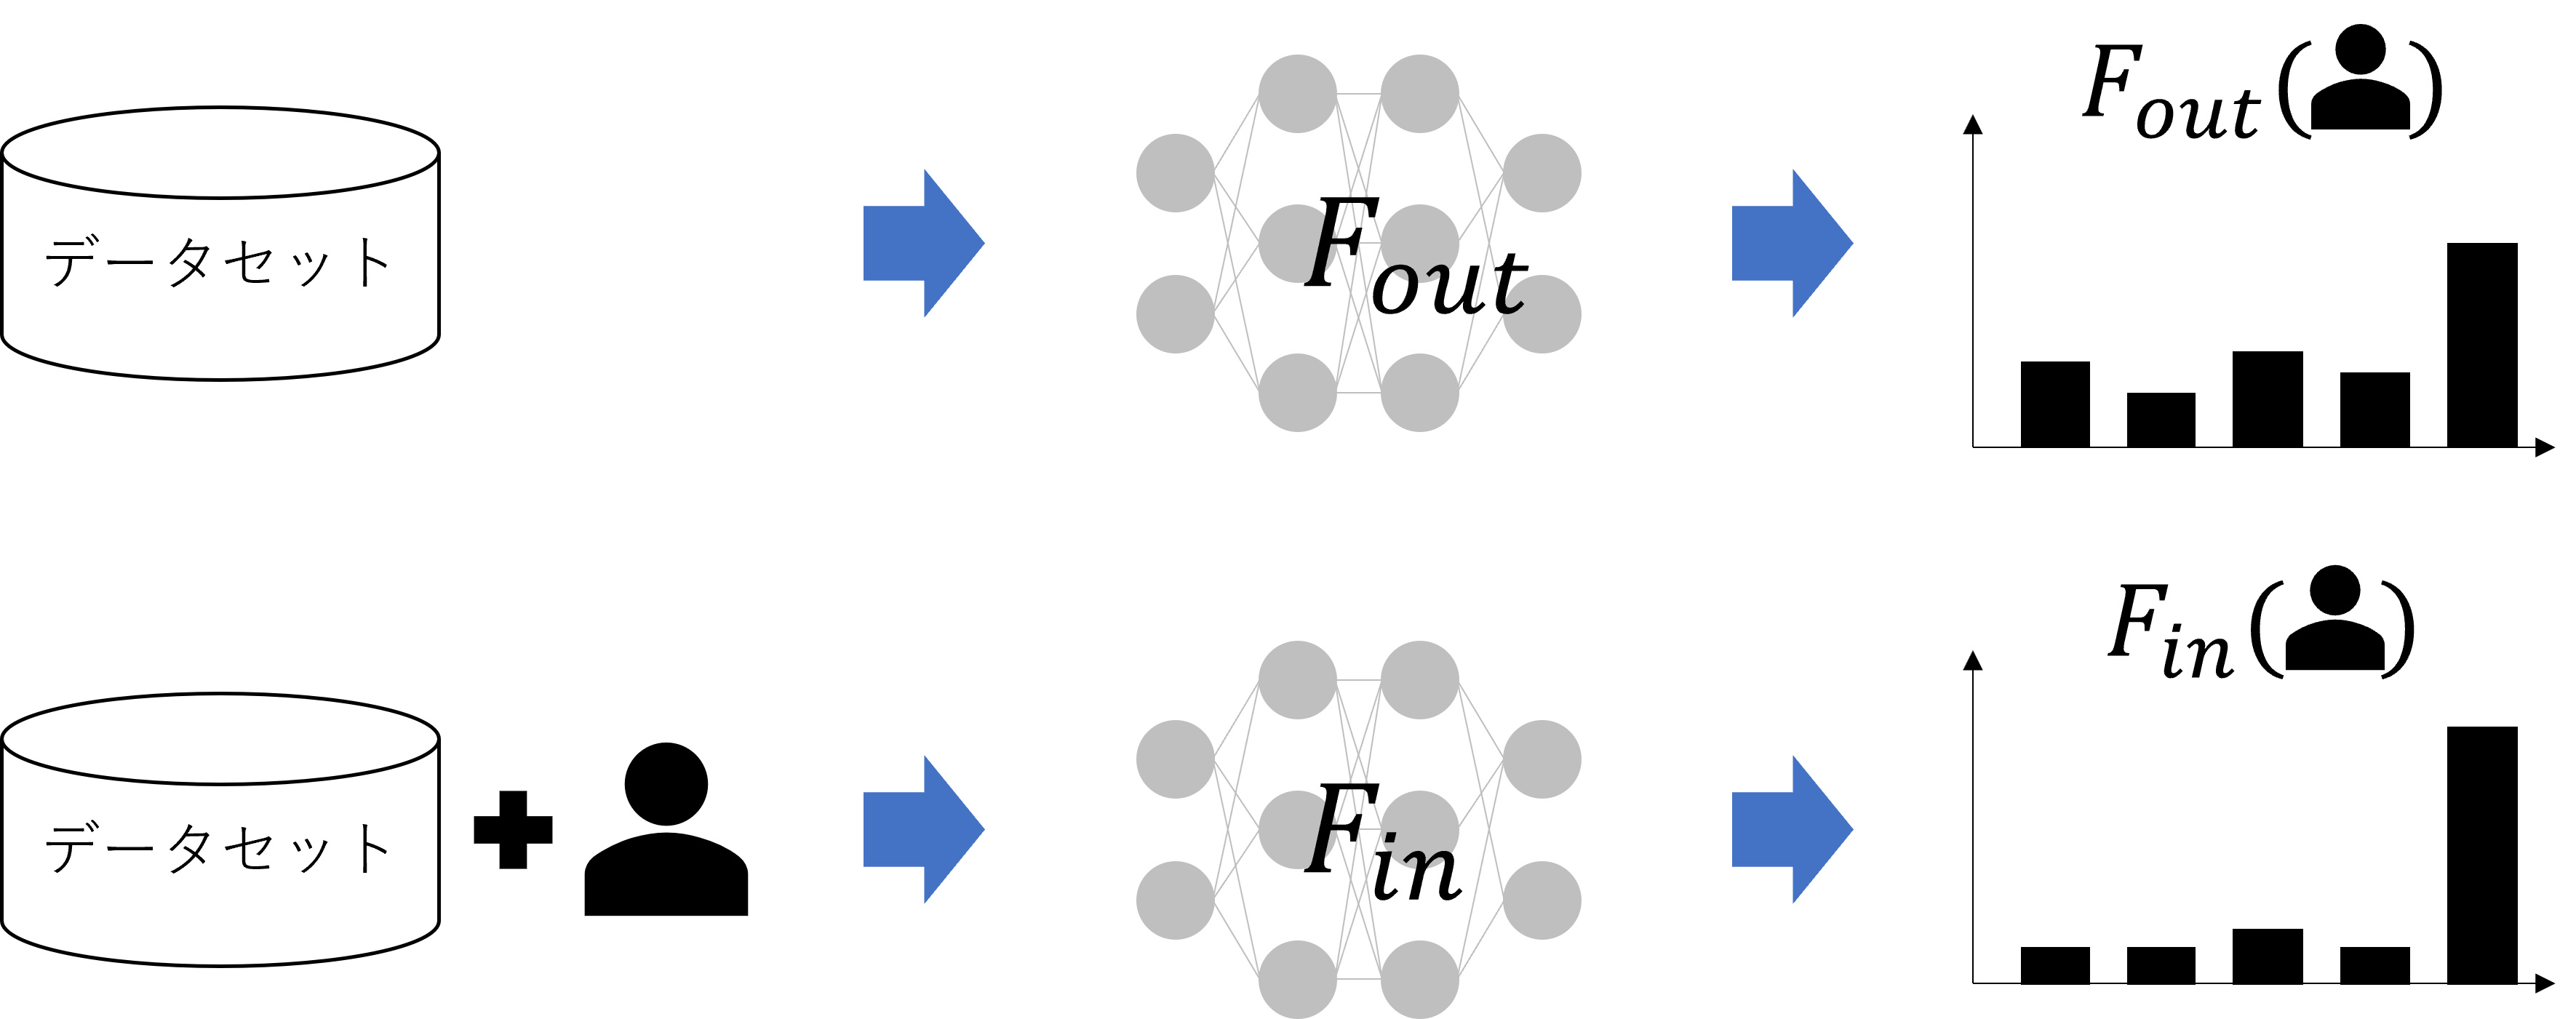


### 評価の手順
1. shadow modelの学習  
データセットを均等に分割し、一方を教師データに使用し（Member）
、もう一方は使用せず（Non-member）shadow model $F_s$の学習を複数回行います。   
2. 攻撃データセットの作成
MemberとNon-memberそれぞれに対して、shadow modelの予測 $F_s(x)$、正解クラス $y$、教師データに含まれていたかどうかのラベル $in/out$を攻撃データセットとして作成します。
3. 攻撃モデルの学習  
正解クラスごとに、$F_s(x)$を入力として$in/out$を予測するモデルの学習を行います。
4. メンバーシップ推定攻撃  
攻撃対象のモデルの出力を攻撃モデルに入力し、教師データに使用されていたか予測します。

shadow model の学習に使用するデータセットの用意の仕方は様々な設定がありますが、今回は少し攻撃者に有利な設定にしてあります。




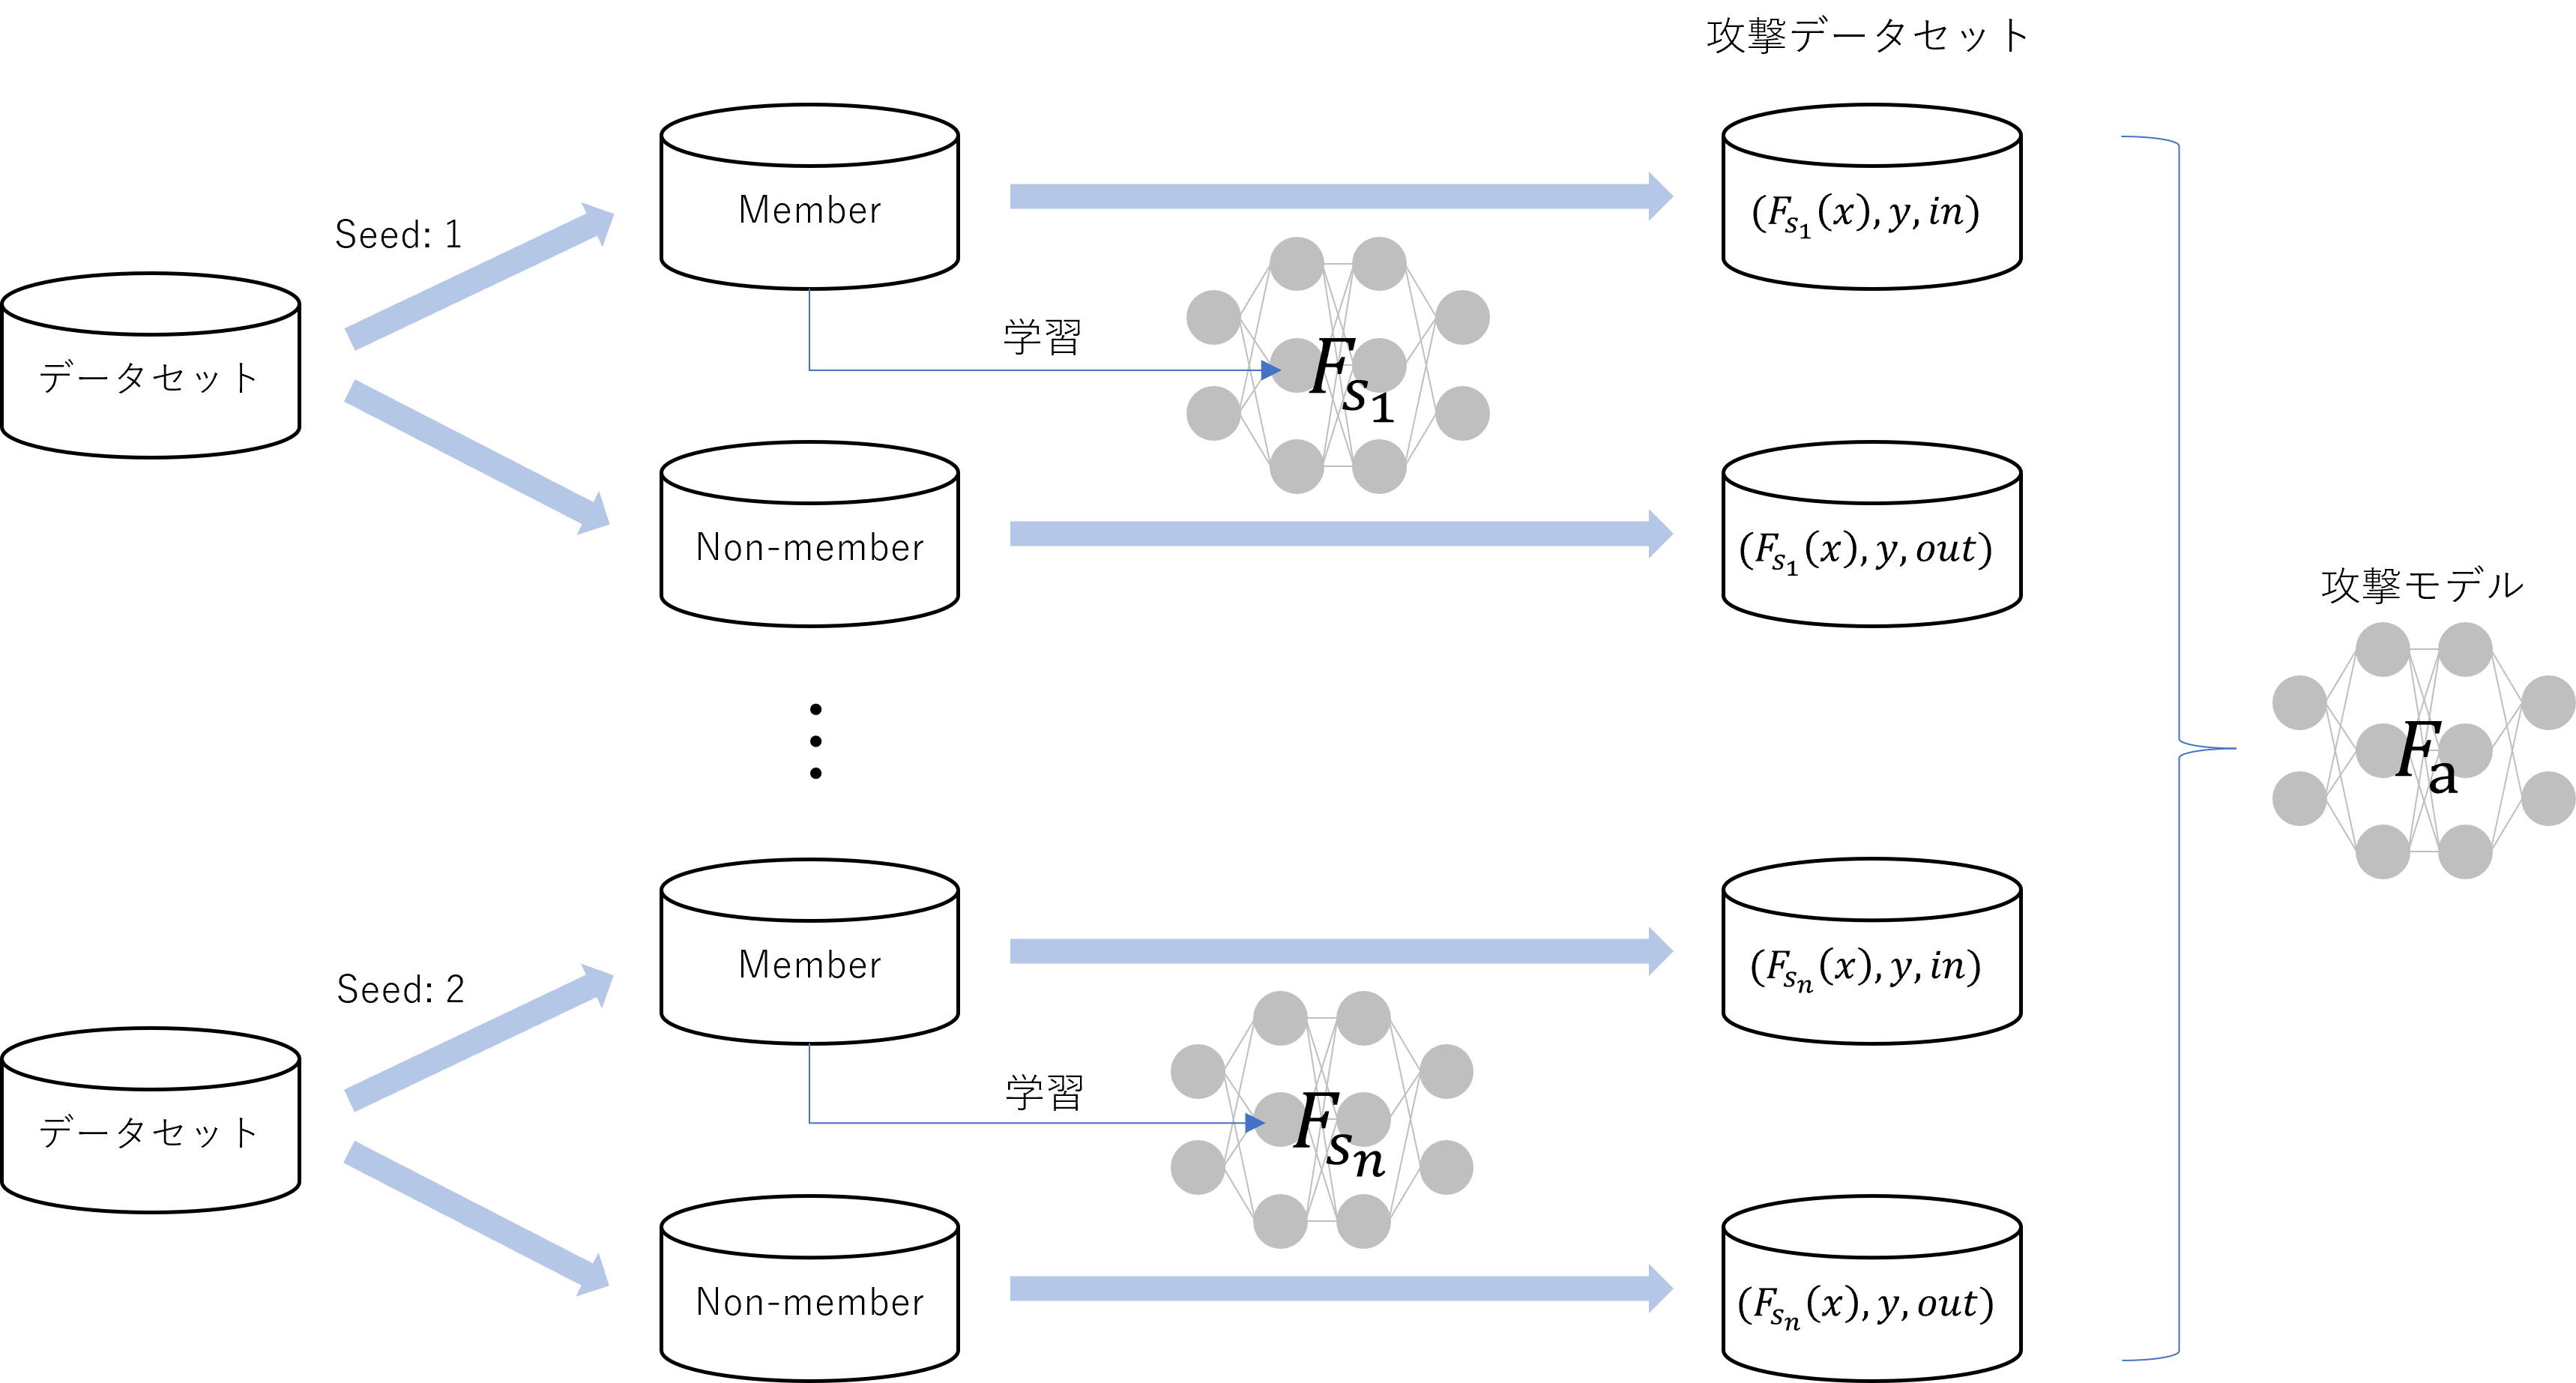

# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import os
import pickle

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 6.2 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
PyTorch: 2.0.0+cu118
Torchvision: 0.15.1+cu118
Opacus: 1.4.0
Tue May  2 00:19:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

### 3. データセットの用意  

カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
全てのデータに、下記の操作を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化

差分プライバシーを適用しない場合のみ、data augmentationを適用するために、data augmentation用の関数も用意しておきます。


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

# for data augmentation
trans = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
    ]
)


100%|██████████| 170498071/170498071 [00:07<00:00, 23175275.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. 学習の関数化

今回は、異なる条件で複数回学習を実行するため、学習部分を関数として定義します。
各エポックのテスト精度と消費した$\epsilon$を出力します。  
教師データの分割では、再現可能なようにシードを固定しています。
学習したモデルは今後再利用可能なように、保存しておきます。  
学習データを半分にしているので、エポック数は30としました。

In [ ]:
def training(batch_size = 512, sigma=1.0, c=1.0, idx=0, dp_flag=0, dir='/content/drive/MyDrive/model'):    
    if dp_flag == 1:
        if os.path.exists(f"{dir}/model_dp_{idx}.pt"):
            print(f"model_dp_{idx}.pt exist")
            return
    else:
        if os.path.exists(f"{dir}/model_{idx}.pt"):
            print(f"model_{idx}.pt exist")
            return

    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    train_dataloader = DataLoader(train_in, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18(num_classes=10)
    # fix model for DP-SGD
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # DP-SGD settig
    if dp_flag == 1:
        privacy_engine = opacus.PrivacyEngine()
        model, optimizer, train_dataloader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            noise_multiplier=sigma,
            max_grad_norm=c,
        )

    # training 
    pbar = tqdm(range(30), desc=f"[idx: {idx}]")
    for epoch in pbar:
            
        if dp_flag == 1:
            with BatchMemoryManager(
                data_loader=train_dataloader, 
                max_physical_batch_size=64, 
                optimizer=optimizer
            ) as memory_safe_data_loader:
                model.train()
                for (X, y) in memory_safe_data_loader:
                    X, y = X.to(device), y.to(device)

                    # optimization step
                    optimizer.zero_grad()
                    pred = model(X)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()
        else:
            model.train()
            for (X, y) in train_dataloader:
                X, y = X.to(device), y.to(device)

                # data augmentation for non-DP
                X = trans(X)

                # optimization step
                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

    # calculate epsilon
    if dp_flag == 1:
        epsilon = privacy_engine.get_epsilon(1e-5)
    else:
        epsilon = -1
    
    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'epsilon: {epsilon}, test accuracy: {test_acc}')

    #save model
    if dp_flag == 1:
        torch.save(model._module.state_dict(), f"{dir}/model_dp_{idx}.pt")
    else:
        torch.save(model.state_dict(), f"{dir}/model_{idx}.pt")

    

### 5. 学習
Google driveにモデルを保存するために、マウントします。
その後、DP-SGDを適用しない場合と、DP-SGDを適用した場合それぞれでモデルの学習を行います。  
今回は、閾値選択に4つのモデルを使用するため、合計で5つのモデルの学習を行います。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for idx in range(10):
    training(batch_size=128, idx=idx)
    training(dp_flag=1, idx=idx)

model_0.pt exist
model_dp_0.pt exist
model_1.pt exist
model_dp_1.pt exist
model_2.pt exist
model_dp_2.pt exist
model_3.pt exist
model_dp_3.pt exist
model_4.pt exist
model_dp_4.pt exist
model_5.pt exist
model_dp_5.pt exist
model_6.pt exist
model_dp_6.pt exist
model_7.pt exist
model_dp_7.pt exist
model_8.pt exist
model_dp_8.pt exist
model_9.pt exist
model_dp_9.pt exist


### 6. メンバーシップ推定攻撃

#### 攻撃データセットの作成
インデックスが1-4のモデルを使用して、攻撃データセットを作成します。




In [ ]:
def make_attack_dataset(target_idx=0, n_models=10, dp_flag=0, dir='/content/drive/MyDrive/'):
    pred_list = []
    ans_list = []
    class_list = []
    for idx in range(n_models):
        if idx == target_idx:
            continue

        #split training data
        train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

        # make dataloader
        in_loader = DataLoader(train_in, batch_size=1024, shuffle=False)
        out_loader = DataLoader(train_out, batch_size=1024, shuffle=False)

        # make model
        model = torchvision.models.resnet18(num_classes=10)
        if dp_flag == 1:
            model = ModuleValidator.fix(model)

        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        if dp_flag == 1:
            fname = f"{dir}/model/model_dp_{idx}.pt"
        else:
            fname = f"{dir}/model/model_{idx}.pt"
        
        model.load_state_dict(torch.load(fname))
        print(f'{fname} loaded')

        # MIA
        # member
        with torch.no_grad():
            for X, y in in_loader:
                X, y = X.to(device), y.to(device)
                
                pred =  torch.nn.Softmax()(model(X))
                pred_list.append(pred.to('cpu').numpy())
                ans_list.append(np.ones(pred.shape[0]))
                class_list.append(y.to('cpu').numpy())
        #non-member
        with torch.no_grad():
            for X, y in out_loader:
                X, y = X.to(device), y.to(device)

                pred =  torch.nn.Softmax()(model(X))
                pred_list.append(pred.to('cpu').numpy())
                ans_list.append(np.zeros(pred.shape[0]))
                class_list.append(y.to('cpu').numpy())
                
    pred = np.concatenate(pred_list)
    ans = np.concatenate(ans_list)
    c = np.concatenate(class_list)
    print(pred.shape)
    print(ans.shape)
    print(c.shape)

    if dp_flag == 1:
        f = open(dir + f'/data/attack_dataset_dp_{target_idx}.pkl', 'wb')
    else:
        f = open(dir + f'/data/attack_dataset_{target_idx}.pkl', 'wb')

    pickle.dump((pred, ans, c), f)

In [ ]:
make_attack_dataset(target_idx=0)
make_attack_dataset(dp_flag=1, target_idx=0)

/content/drive/MyDrive//model/model_1.pt loaded
/content/drive/MyDrive//model/model_2.pt loaded
/content/drive/MyDrive//model/model_3.pt loaded
/content/drive/MyDrive//model/model_4.pt loaded
/content/drive/MyDrive//model/model_5.pt loaded
/content/drive/MyDrive//model/model_6.pt loaded
/content/drive/MyDrive//model/model_7.pt loaded
/content/drive/MyDrive//model/model_8.pt loaded
/content/drive/MyDrive//model/model_9.pt loaded
(450000, 10)
(450000,)
(450000,)
/content/drive/MyDrive//model/model_dp_1.pt loaded
/content/drive/MyDrive//model/model_dp_2.pt loaded
/content/drive/MyDrive//model/model_dp_3.pt loaded
/content/drive/MyDrive//model/model_dp_4.pt loaded
/content/drive/MyDrive//model/model_dp_5.pt loaded
/content/drive/MyDrive//model/model_dp_6.pt loaded
/content/drive/MyDrive//model/model_dp_7.pt loaded
/content/drive/MyDrive//model/model_dp_8.pt loaded
/content/drive/MyDrive//model/model_dp_9.pt loaded
(450000, 10)
(450000,)
(450000,)


#### 攻撃モデルの学習
3層のニューラルネットワークを用いて攻撃モデルの学習を行います。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FC(nn.Module):
    def __init__(self, num_class=2, input_size=10, num_layer=3, num_unit=100):
        super().__init__()
        self.num_layer=num_layer
        self.l1 = nn.Linear(in_features=input_size,out_features=num_unit)
        self.l2 = nn.Linear(in_features=num_unit, out_features=num_unit)
        self.l3 = nn.Linear(in_features=num_unit, out_features=num_class)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [ ]:
def train_attack_model(target_idx=0, n_models=10, dp_flag=0, dir='/content/drive/MyDrive/'):
    if dp_flag == 1:
        f = open(dir + f'/data/attack_dataset_dp_{target_idx}.pkl', 'rb')
    else:
        f = open(dir + f'/data/attack_dataset_{target_idx}.pkl', 'rb')

    (pred, ans, c) = pickle.load(f)
    
    for class_idx in range(10):
        x = pred[c==class_idx]
        y = ans[c==class_idx]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.int64)
        train_dataset = torch.utils.data.TensorDataset(x, y)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=128,
            shuffle=True
        )
        
        model = FC()
        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        model.train()

        criterion = torch.nn.CrossEntropyLoss()
        # training attack dataset
        pbar = tqdm(range(30), desc=f"[class idx: {class_idx}]")
        for epoch in pbar:
            losses = []
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                pbar.set_postfix(loss=np.mean(losses))
        
        if dp_flag == 1:
            torch.save(model.state_dict(), f"{dir}/model/attack_dp_{target_idx}_{class_idx}.pt")
        else:
            torch.save(model.state_dict(), f"{dir}/model/attack_{target_idx}_{class_idx}.pt")
        


In [ ]:
train_attack_model()
train_attack_model(dp_flag=1)

[class idx: 9]: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it, loss=0.692]


#### メンバーシップ推定攻撃の実行
攻撃モデルを用いて、教師データに含まれていたかを予測するメンバーシップ推定攻撃を行います。

In [ ]:
def MIA(idx=0, dp_flag=0, dir='/content/drive/MyDrive/'):

    
    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    in_loader = DataLoader(train_in, batch_size=1024, shuffle=False)
    out_loader = DataLoader(train_out, batch_size=1024, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)


    # make model
    model = torchvision.models.resnet18(num_classes=10)
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)


    if dp_flag == 1:
        fname = f"{dir}/model/model_dp_{idx}.pt"
    else:
        fname = f"{dir}/model/model_{idx}.pt"
    
    model.load_state_dict(torch.load(fname))
    print(f'{fname} loaded')

    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'test accuracy: {test_acc}')

    # MIA
    pred_list = []
    ans_list = []
    class_list = []
    # member
    with torch.no_grad():
        for X, y in in_loader:
            X, y = X.to(device), y.to(device)
            
            pred =  torch.nn.Softmax()(model(X))
            pred_list.append(pred.to('cpu').numpy())
            ans_list.append(np.ones(pred.shape[0]))
            class_list.append(y.to('cpu').numpy())
            
    
    #non-member
    with torch.no_grad():
        for X, y in out_loader:
            X, y = X.to(device), y.to(device)

            pred = torch.nn.Softmax()(model(X))
            pred_list.append(pred.to('cpu').numpy())
            ans_list.append(np.zeros(pred.shape[0]))
            class_list.append(y.to('cpu').numpy())
                

    pred = np.concatenate(pred_list)
    ans = np.concatenate(ans_list)
    c = np.concatenate(class_list)

    inference_list = []
    ans_list = []

    for class_idx in range(10):    
        model = FC()
        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        if dp_flag == 1:
            fname = f"{dir}/model/attack_dp_{idx}_{class_idx}.pt"
        else:
            fname = f"{dir}/model/attack_{idx}_{class_idx}.pt"
        model.load_state_dict(torch.load(fname))

        x = pred[c==class_idx]
        y = ans[c==class_idx]

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.int64)
        dataset = torch.utils.data.TensorDataset(x, y)
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=1024,
            shuffle=False
        )
        
        model.eval()
        with torch.no_grad():
            for data, target in loader:
                data = data.to(device)
                output =  torch.nn.Softmax()(model(data))
                inference_list.append(output[:,1].to('cpu').numpy())
                ans_list.append(target)

    inference = np.concatenate(inference_list)
    ans = np.concatenate(ans_list)
    inference_binary = np.zeros(ans.shape)
    inference_binary[inference > 0.5] = 1    
    mia_acc = metrics.accuracy_score(ans, inference_binary)
    print(f'MIA accuracy: {mia_acc}')

    cm = metrics.confusion_matrix(ans, inference_binary)
    print(cm)    
    print()

    fpr, tpr, threshold = metrics.roc_curve(y_true = ans, y_score = inference)
    
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    plt.subplot(122)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()


/content/drive/MyDrive//model/model_0.pt loaded
test accuracy: 0.7793
MIA accuracy: 0.54172
[[ 6596 18404]
 [ 4510 20490]]



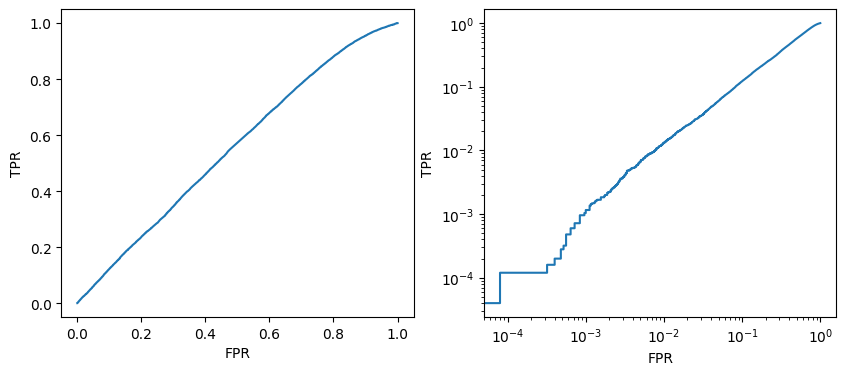

/content/drive/MyDrive//model/model_dp_0.pt loaded
test accuracy: 0.5036
MIA accuracy: 0.51338
[[11952 13048]
 [11283 13717]]



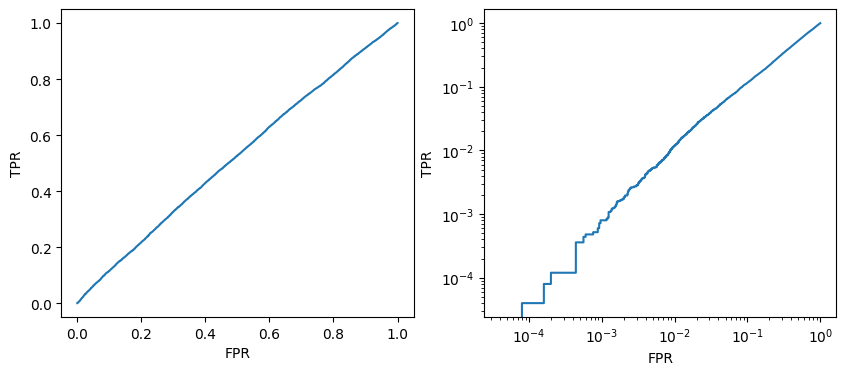

In [ ]:
MIA()
MIA(dp_flag=1)

# おわりに


### 今回の結果
機械学習ベースのメンバーシップ推定攻撃の成功率は、閾値ベースのメンバーシップ推定攻撃とあまり変わりませんでした。
ただし、攻撃対象モデルの学習の設定、shadow modelの学習に用いるデータセットの設定などによって結果は異なると考えられるため、様々な設定で実験をする必要があると思います。


### 次にやること
より高度なメンバーシップ推定攻撃として、サンプルごとの尤度比に基づいて教師データに含まれていたか判定する手法を検証したいと思います。
